In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from config_loader import load_config
import os
import json

In [2]:
# Load configuration
config, config_dir = load_config()
# Get the data path from the configuration
env = config['Settings']['environment']
data_path = config[env]['data_path']
demo_inferred_data_file = config['Data']['inferred_data_file']
demo_dataset_ground_truth_file = config['Data']['demo_dataset_ground_truth_file']
column_names_file = config['Data']['training_dataset_columns_file']

In [3]:
# Read appliance names from the text file
with open(os.path.join(data_path, column_names_file), 'r') as file:
    column_names_json = json.load(file)

# Read the Parquet file
df = pd.read_parquet(os.path.join(data_path, demo_inferred_data_file))
# Read the ground truth data
df_gt = pd.read_parquet(os.path.join(data_path, demo_dataset_ground_truth_file))

print(df.head())
print(df_gt.head())

   timestamp       appliance      value        date  minute  hour    month
0 2025-04-07  Coffee Machine   0.000000  2025-04-07       0     0  2025-04
1 2025-04-07       Microwave   8.100359  2025-04-07       0     0  2025-04
2 2025-04-07          Router  19.107155  2025-04-07       0     0  2025-04
3 2025-04-07          Laptop   1.515010  2025-04-07       0     0  2025-04
4 2025-04-07            Lamp   1.308143  2025-04-07       0     0  2025-04
                 timestamp household_id  Coffee Machine  Dryer  Freezer  \
423360 2025-04-07 00:00:00           05             0.0    0.0      0.0   
423361 2025-04-07 00:00:10           05             0.0    0.0      0.0   
423362 2025-04-07 00:00:20           05             0.0    0.0      0.0   
423363 2025-04-07 00:00:30           05             0.0    0.0      0.0   
423364 2025-04-07 00:00:40           05             0.0    0.0      0.0   

          Fridge  Lamp  Laptop  Microwave        PC  Router   Tablet  \
423360  4.657941   0.0     

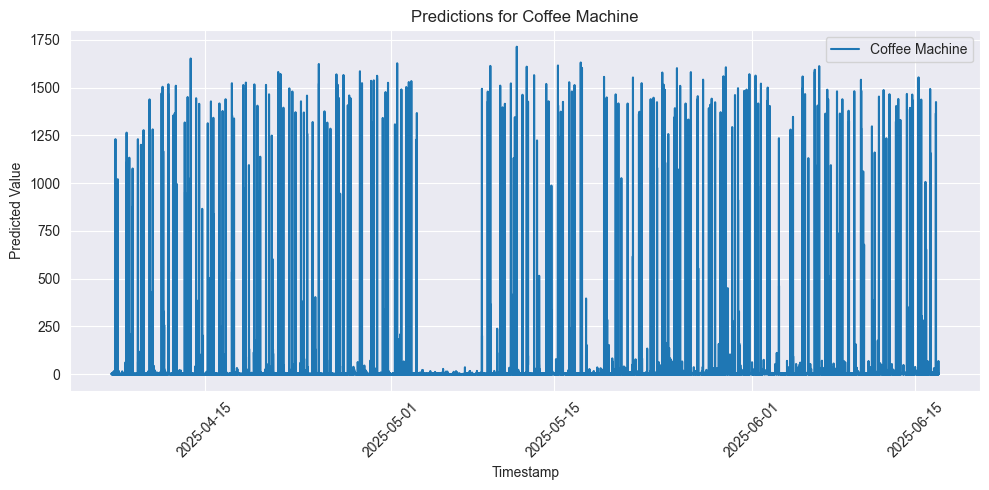

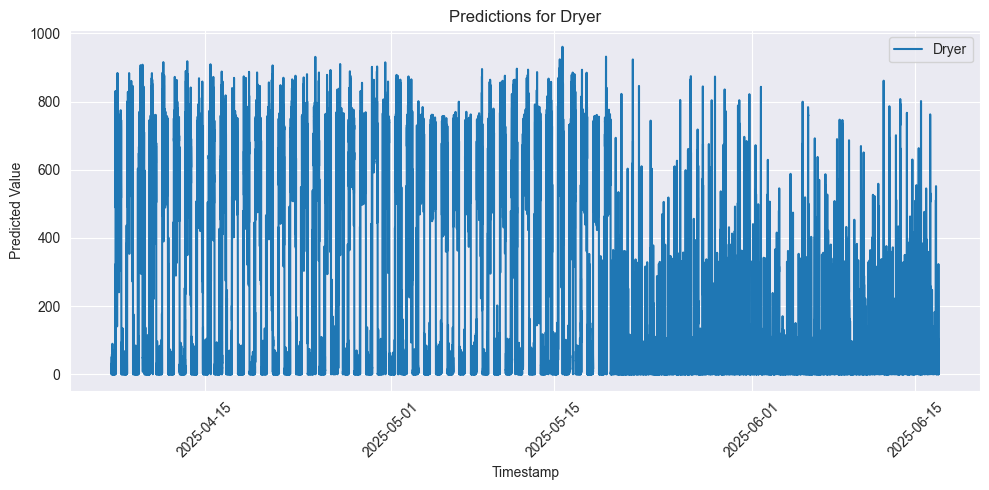

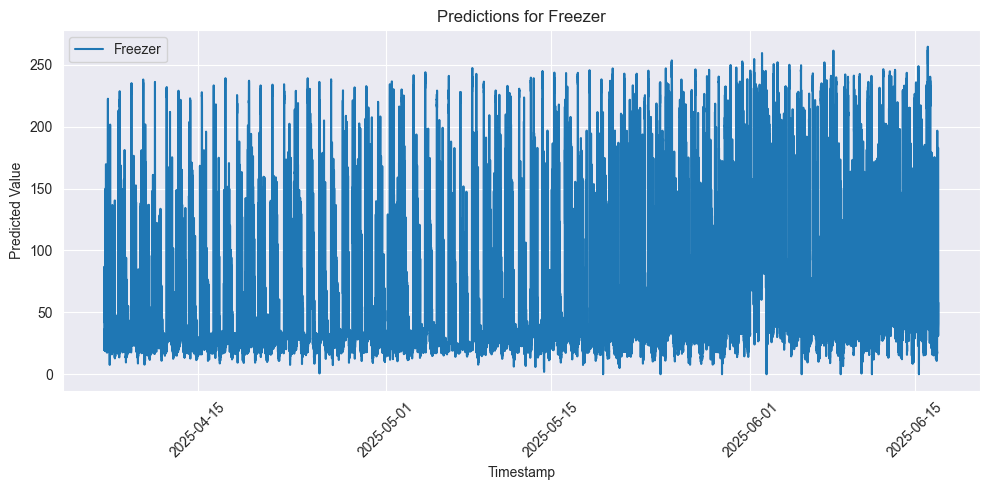

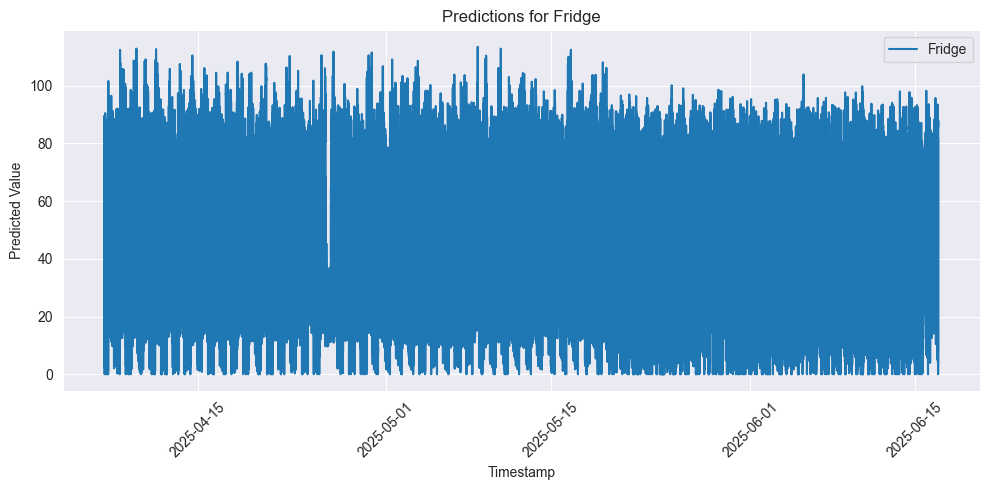

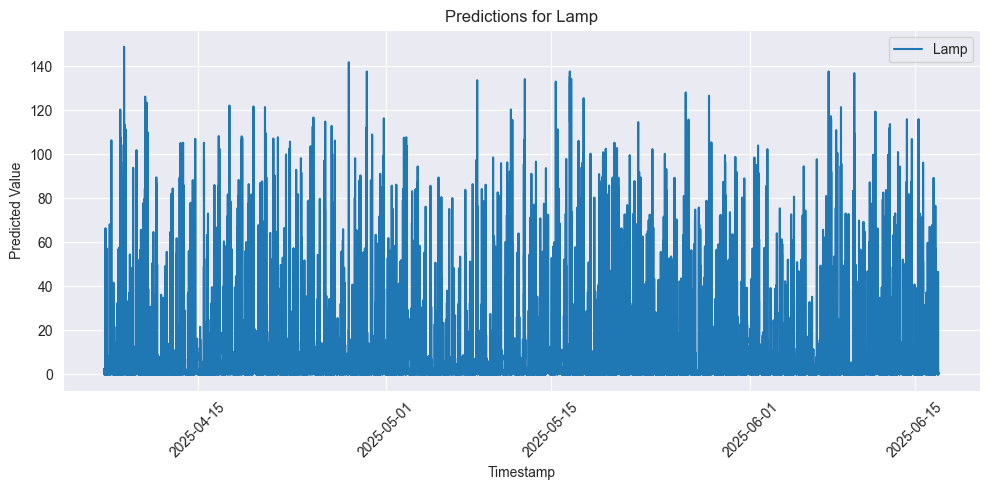

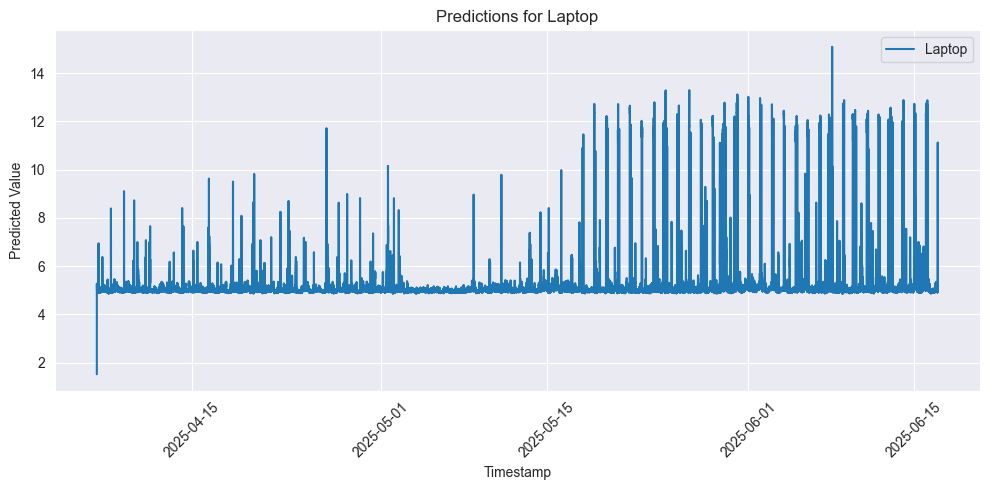

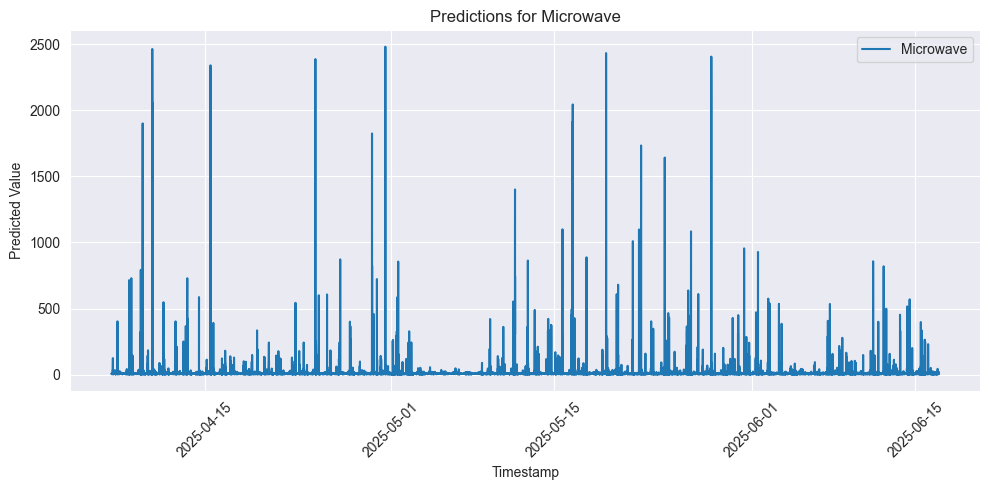

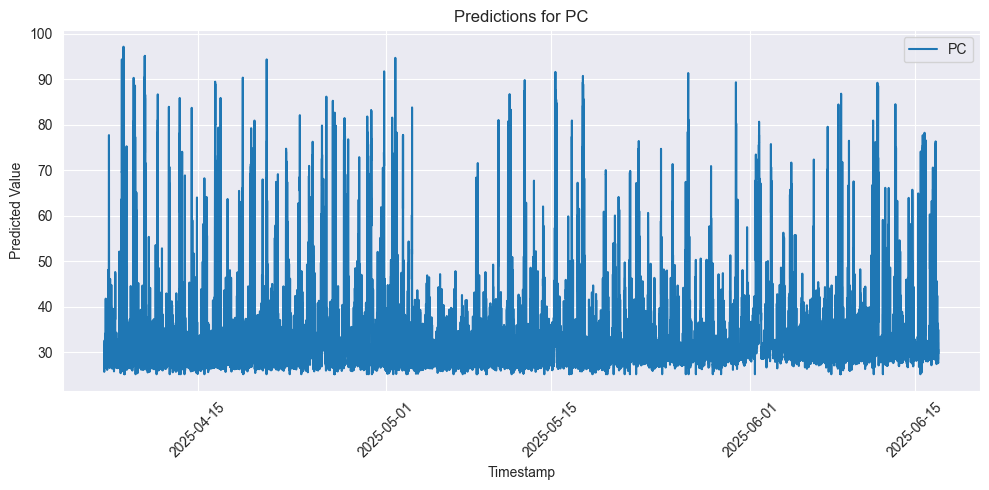

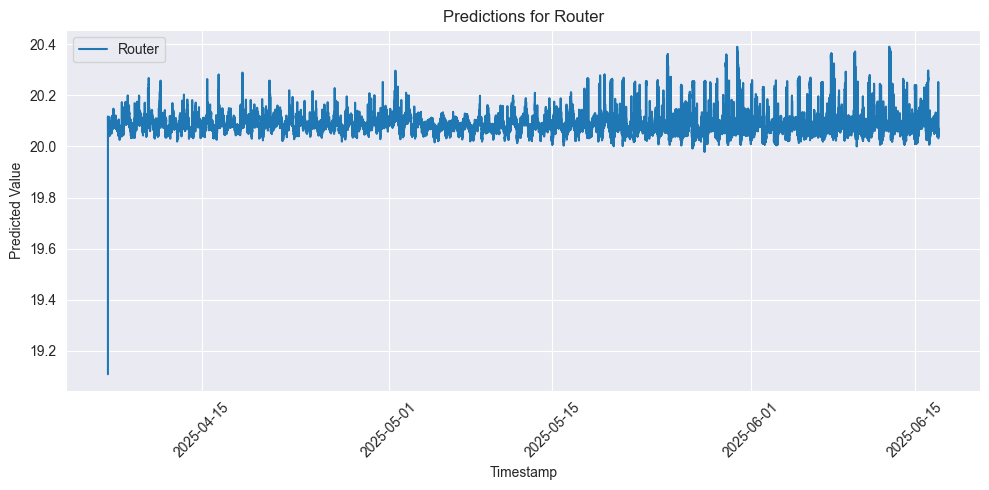

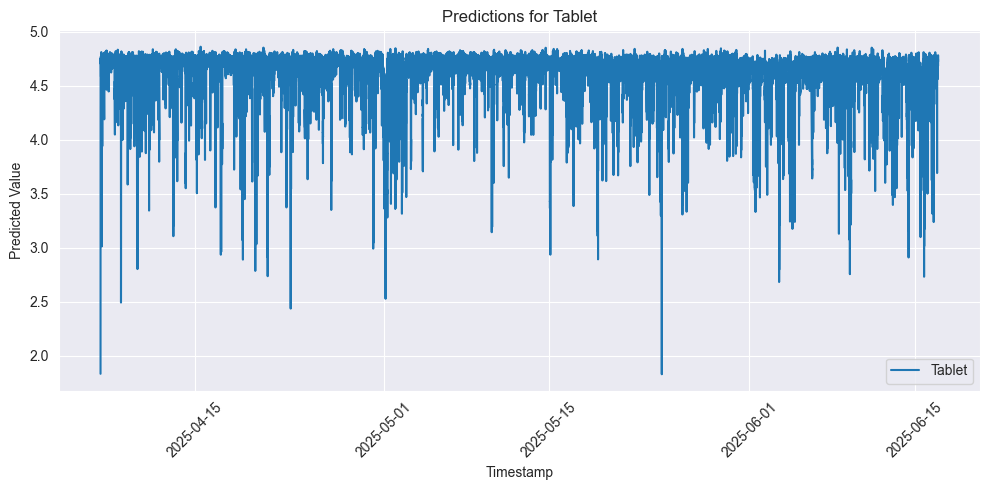

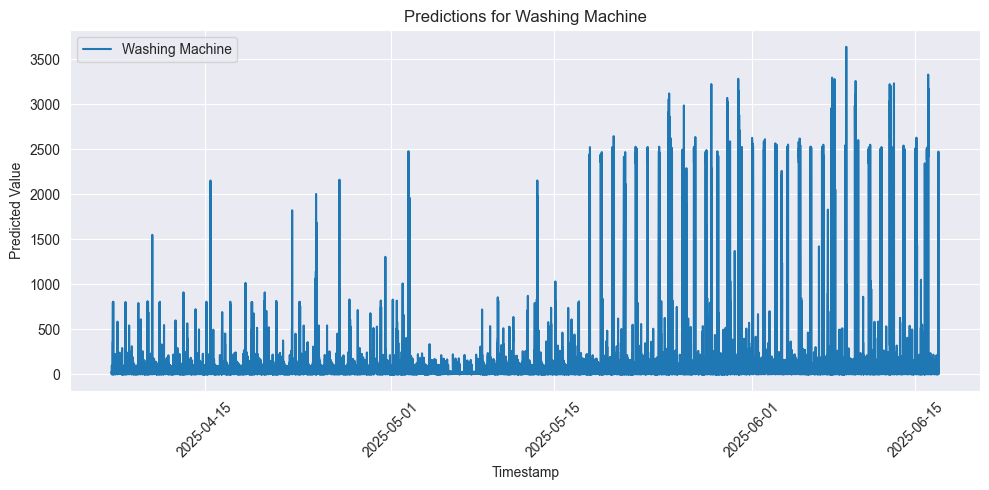

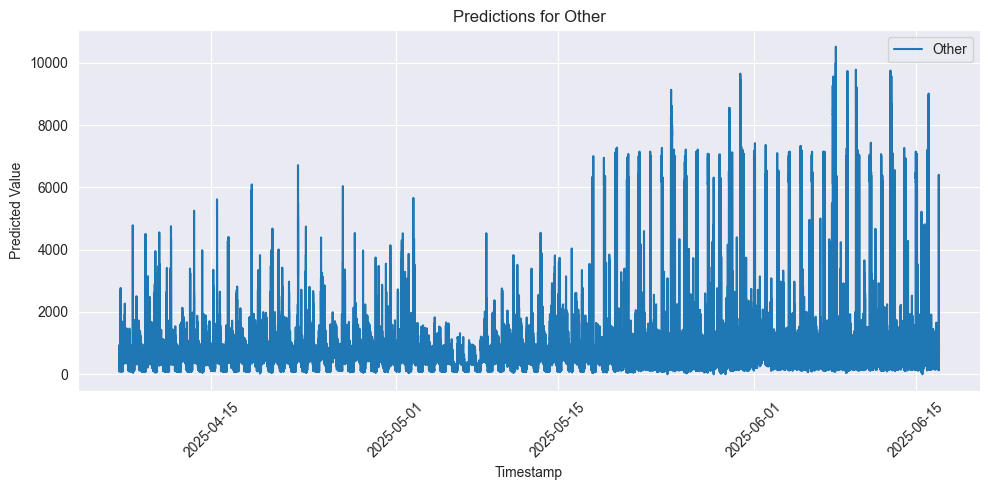

In [4]:
appliances = column_names_json['appliances']

# Loop over each appliance
for appliance in appliances:
    df_appliance = df[df['appliance'] == appliance]
    plt.figure(figsize=(10, 5))
    plt.plot(df_appliance['timestamp'], df_appliance['value'], label=appliance)
    plt.title(f'Predictions for {appliance}')
    plt.xlabel('Timestamp')
    plt.ylabel('Predicted Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [5]:
import pandas as pd
import plotly.graph_objects as go
from datetime import timedelta

# Convert timestamps to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_gt['timestamp'] = pd.to_datetime(df_gt['timestamp'])

# Convert wide ground truth to long format
gt_long = df_gt.melt(
    id_vars=['timestamp'],
    value_vars=appliances,
    var_name='appliance',
    value_name='gt_value'
)

# Merge predictions and ground truth
merged = pd.merge(df, gt_long, on=['timestamp', 'appliance'], how='inner')

# Filter to first 7 days of data
start_date = merged['timestamp'].min()
end_date = start_date + timedelta(days=7)
merged_7d = merged[(merged['timestamp'] >= start_date) & (merged['timestamp'] < end_date)]

import os

os.makedirs("plots", exist_ok=True)  # Create a folder to store the HTMLs

for appliance in appliances:
    df_appliance = merged_7d[merged_7d['appliance'] == appliance]

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df_appliance['timestamp'],
        y=df_appliance['gt_value'],
        mode='lines',
        name='Ground Truth',
        line=dict(color='red')
    ))

    fig.add_trace(go.Scatter(
        x=df_appliance['timestamp'],
        y=df_appliance['value'],
        mode='lines',
        name='Prediction',
        line=dict(color='blue')
    ))

    fig.update_layout(
        title=f'Prediction vs Ground Truth: {appliance}',
        xaxis_title='Timestamp',
        yaxis_title='Power (W)',
        legend=dict(x=0, y=1.1, orientation="h"),
        height=400
    )

    # Save to HTML file
    fig.write_html(f"plots/{appliance}.html")



                 Total Energy (Wh)  Percentage (%)
appliance                                         
Other                 1.047232e+06       55.199478
Dryer                 3.595456e+05       18.951599
Washing Machine       1.821585e+05        9.601551
Freezer               9.552625e+04        5.035176
Fridge                7.158444e+04        3.773206
PC                    5.615051e+04        2.959686
Router                3.422439e+04        1.803963
Microwave             1.928035e+04        1.016265
Coffee Machine        9.158816e+03        0.482760
Laptop                8.910807e+03        0.469687
Tablet                7.871698e+03        0.414916
Lamp                  5.534302e+03        0.291712


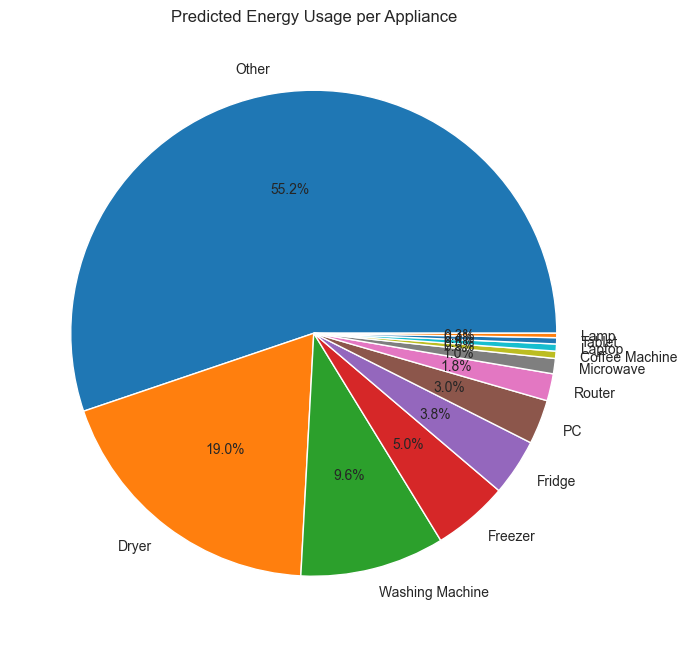

In [6]:
# Step 1: Define interval and conversion factor (10 seconds → Wh)
interval_seconds = 10
conversion_factor = interval_seconds / 3600  # 0.00278 Wh per W

# Step 2: Compute instantaneous energy (Wh) for each row
df['energy_Wh'] = df['value'] * conversion_factor

# Step 3: Group by appliance and sum energy
energy_by_appliance = df.groupby('appliance')['energy_Wh'].sum().sort_values(ascending=False)

# Step 4: Calculate total and percentage
total_energy_Wh = energy_by_appliance.sum()
percent_by_appliance = (energy_by_appliance / total_energy_Wh) * 100

# Step 5: Combine into a summary DataFrame
predicted_energy_summary = pd.DataFrame({
    'Total Energy (Wh)': energy_by_appliance,
    'Percentage (%)': percent_by_appliance
})

print(predicted_energy_summary)

import matplotlib.pyplot as plt

predicted_energy_summary['Percentage (%)'].plot.pie(
    autopct='%1.1f%%', figsize=(7, 7), title='Predicted Energy Usage per Appliance'
)
plt.ylabel("")
plt.tight_layout()
plt.show()
